# Support Vector Machines

## Introduction

We will be using the cancer dataset for these exercises. This data set contains various properties of tumour like radius_mean, texture_mean, perimeter_mean, area_mean, etc. It also contains a diagnosis that states whether it is Malignant or Benign. 

In [256]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [257]:
data=pd.read_csv("cancer_data.csv")
data=data.drop('Unnamed: 32',axis=1)
data=data.fillna(data.mean())

### highly predictive variables were removed to make the model challenging
data = data.drop(['texture_worst', 'symmetry_worst', 'concave points_mean', 'radius_se', 'concave points_worst',
                 'smoothness_worst' , 'radius_worst', 'area_worst', 'texture_mean', 'perimeter_worst', 'area_mean', 
                 'area_se',  'concavity_mean', 'concavity_worst', 'fractal_dimension_se', 'fractal_dimension_worst',
                 'compactness_worst', 'compactness_se', 'perimeter_mean', 'radius_mean', 'compactness_mean',
                  'perimeter_se', 'fractal_dimension_mean'], axis=1)

In [258]:
data.head()

,id,diagnosis,smoothness_mean,symmetry_mean,texture_se,smoothness_se,concavity_se,concave points_se,symmetry_se
0,842302,M,0.11840,0.2419,0.9053,0.006399,0.05373,0.01587,0.03003
1,842517,M,0.08474,0.1812,0.7339,0.005225,0.01860,0.01340,0.01389
2,84300903,M,0.10960,0.2069,0.7869,0.006150,0.03832,0.02058,0.02250
3,84348301,M,0.14250,0.2597,1.1560,0.009110,0.05661,0.01867,0.05963
4,84358402,M,0.10030,0.1809,0.7813,0.011490,0.05688,0.01885,0.01756


In [259]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 9 columns):
id                   569 non-null int64
diagnosis            569 non-null object
smoothness_mean      569 non-null float64
symmetry_mean        569 non-null float64
texture_se           569 non-null float64
smoothness_se        569 non-null float64
concavity_se         569 non-null float64
concave points_se    569 non-null float64
symmetry_se          569 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 40.1+ KB


We will standardise the variables and create train and test datasets

In [260]:
X=data.drop('diagnosis',axis=1)
Y=data['diagnosis']
xc = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Standardization of columns
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

X_train_std=sc.fit_transform(X_train)
X_test_std=sc.transform(X_test)

X_std=sc.fit_transform(X)
X = pd.DataFrame(X_std, columns=xc)

X_train = pd.DataFrame(X_train_std, columns=xc)
X_test = pd.DataFrame(X_test_std, columns=xc)

### GridSearchCV for identifying the optimal hyperparameter

In [261]:
def svc_param_selection(X, y, nfolds):
    C_range = np.logspace(-3, 2, 6)
    gamma_range = np.logspace(-3, 2, 6)
    param_grid = dict(gamma=gamma_range, C=C_range)
    #print(param_grid)
 
    grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    #predicted=grid_search.predict(X_test)
    #score=accuracy_score(y_test, predicted)
    return grid_search.best_params_
 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
param=svc_param_selection(X_train,y_train,cv)
print (param)

{'C': 0.1, 'gamma': 0.001}


Let's understand the importance of columns 

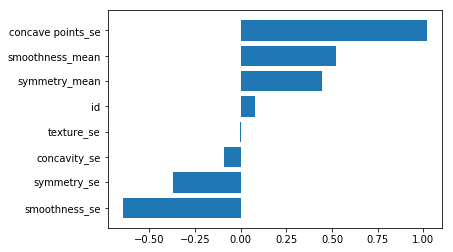

In [262]:
sv = SVC(**param, kernel='linear', probability=True)

from matplotlib import pyplot as plt
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names =list(X_train)

sv.fit(X_train, y_train)
f_importances(sv.coef_.reshape(sv.coef_.shape[1]), features_names)

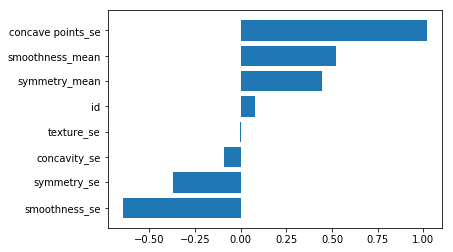

In [263]:
sv = SVC(**param, kernel='linear', probability=True)

from matplotlib import pyplot as plt
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names =list(X_train)

sv.fit(X_train, y_train)
f_importances(sv.coef_.reshape(sv.coef_.shape[1]), features_names)

Let's apply optimized C and gamma to finalize the model

In [241]:
sv = SVC(C=0.1, gamma=0.001, probability=True, kernel='linear')
sv.fit(X_train, y_train)

y_pred = sv.predict(X_test)
y_prob = sv.predict_proba(X_test)

In [242]:
print(param)
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

{'C': 0.1, 'gamma': 0.001}


[[73 16]
 [10 44]]


             precision    recall  f1-score   support

          B       0.88      0.82      0.85        89
          M       0.73      0.81      0.77        54

avg / total       0.82      0.82      0.82       143



## ROC curve for model evaluation

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point — a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. 

In [227]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], pos_label='M')
roc_auc = auc(fpr, tpr)

print(roc_auc)

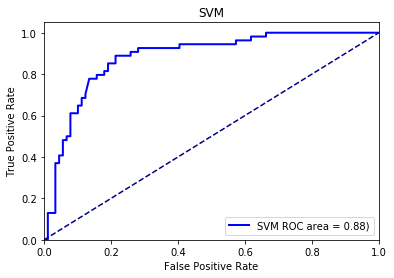

In [228]:
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('SVM')
plt.plot(fpr, tpr, color='blue', lw=2, label='SVM ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [24]:
thresholds

array([0.99463308, 0.96225882, 0.93545683, 0.93545676, 0.93527915,
       0.93093222, 0.90458913, 0.42267158, 0.40467051, 0.36228688,
       0.35683306, 0.34801443, 0.34684695, 0.34238905, 0.33293742,
       0.33130686, 0.31981271, 0.30616765, 0.30196495, 0.30014464,
       0.2992724 , 0.29687278, 0.29028184, 0.28582587, 0.27495387,
       0.27056753, 0.13750916, 0.12348832, 0.04083975])

### Hyperparamter optimization through Bayesian approach (hyperopt)
Let's now apply hyper optimization to determine the optimal parameter values

In [230]:
def hyperopt_train_test(params):
    clf = SVC(**params)
    return cross_val_score(clf, X, Y).mean()

space4svm = {
    'C': hp.loguniform('C', -3, 2),
    'gamma': hp.loguniform('gamma', -3, 2),
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()

best = fmin(f, space4svm, algo=tpe.suggest, max_evals=1000, trials=trials)

print ('best:')
print (best)

best:
{'C': 0.8779288161908119, 'gamma': 0.10499272461163646}


In [231]:
from hyperopt import space_eval

#sv=svm.SVC()

# Get the values of the optimal parameters
best_params = space_eval(space4svm, best)

# Fit the model with the optimal hyperparamters

sv=SVC(**best_params, probability=True)

#sv.set_params(**best_params, probability=True)
sv.fit(X_train, y_train)

# Score with the test data
y_prob = sv.predict_proba(X_test)
y_pred = sv.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], pos_label='M')
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9053266749895963


In [254]:
print('\n')
print(classification_report(y_test,y_pred))



             precision    recall  f1-score   support

          B       0.88      0.82      0.85        89
          M       0.73      0.81      0.77        54

avg / total       0.82      0.82      0.82       143



In [255]:
cm = confusion_matrix(y_test,y_pred)
cm = cm.astype('float')*100 / cm.sum(axis=1)[:, np.newaxis]
print (confusion_matrix(y_test,y_pred))
print('\n')
print (cm)

[[73 16]
 [10 44]]


[[82.02247191 17.97752809]
 [18.51851852 81.48148148]]


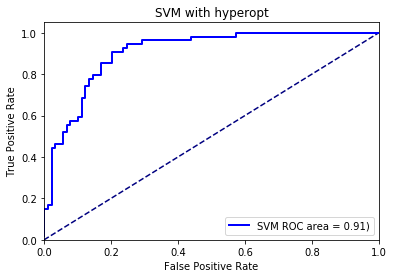

In [233]:
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('SVM with hyperopt')
plt.plot(fpr, tpr, color='blue', lw=2, label='SVM ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [245]:
sv

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [244]:
best_params

{'C': 0.8779288161908119, 'gamma': 0.10499272461163646}

This is a simple illusstration of application of hyperparameter tuning for SVM. We tried gridsearch and bayesian. The result was marginally better for bayesian.